# **Image Classification on Fashion-MNIST Dataset**
**Implementing a neural network for classifying images from Fashion-MNIST dataset, using PyTorch, Cross Entropy loss function and SGD optimizer**.<br>
**Author:** *Mahdi Rafati*

---

## **Import Libraries**

In [49]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

# Our Libraries
from utils.predict_utils import *
from utils.vis_utils import *

## **Loading the Dataset**

In [6]:
# Load training data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
# Load test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

## **Iterating and Visualizing the Dataset**

Looking at some sample data

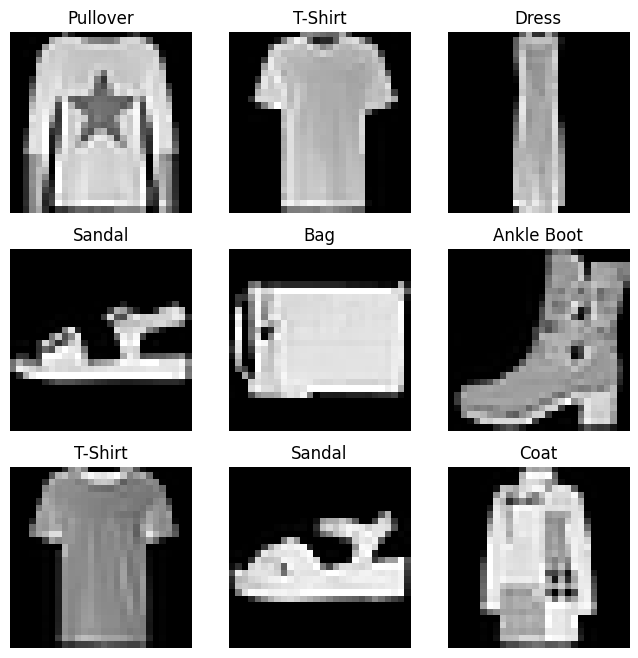

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  # Choose a random sample from data
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  # Add sample image to the figure as a subplot
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

## **Creating a Custom Dataset for Our Files**
This implementation could be useful when we are working with our own dataset not with one from PyTorch.

In [8]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None,
               target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    # Catching image and its label
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]

    # Perform transfomations if needed
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

## **Preparing the Data for Training with DataLoaders**

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## **Iterate Through the DataLoader**

Just seen the data in DataLoader by making it a iterable object.

Feature batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


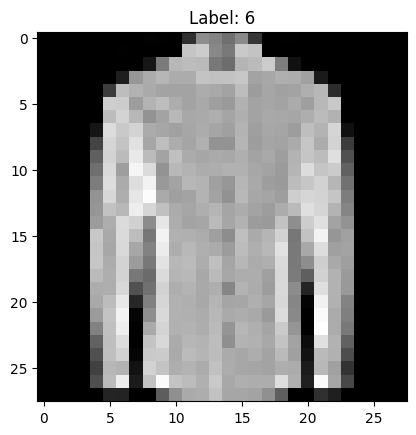

In [10]:
# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Label batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.title(f"Label: {label.item()}")
plt.show()

## **Build the Neural Network**

In [11]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### **Get Device for Training**
Choosing the processor which is available in your device.

In [12]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Using {device} device")

Using cuda device


### **Define the Network Class**

In [13]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [14]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [15]:
# Giving an example to the model
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4], device='cuda:0')


### **Showing Model Parameters:**
Here you can see the model's parameters:

In [16]:
print(f"Model Structure: {model}\n\n")

for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]}")

Model Structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[-0.0150, -0.0023,  0.0265,  ..., -0.0131, -0.0248, -0.0169],
        [ 0.0121, -0.0204,  0.0137,  ...,  0.0208,  0.0324,  0.0261]],
       device='cuda:0', grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([-0.0179, -0.0222], device='cuda:0', grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0076, -0.0339, -0.0020,  ...,  0.0337,  0.0163, -0.0436],
        [-0.0132,  0.0121, -0.0271,  ...,  0.0306,  0.0367,  0.0426]],
       device='cuda:0', grad_fn=<SliceBack

## **Train and Omptimize Model Parameters**

### **Define Training Loop and Test Loop**

In [38]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
  size = len(dataloader.dataset)
  # Set the model training mode
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # Move tensors to the available device
    X = X.to(device)
    y = y.to(device)
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    if batch % 100 == 0:
      loss, current = loss.item(), batch * batch_size + len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      losses.append(loss)

def test_loop(dataloader, model, loss_fn, device):
  # Set the model to evaluation mode
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  # Evaluating the model with torch.nograd() ensures that no gradients are computed during test mode
  # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
  with torch.no_grad():
    for X, y in dataloader:
      # Move tensors to the available device
      X = X.to(device)
      y = y.to(device)

      pred = model(X)
      test_loss = loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.3f}%, Avg loss: {test_loss:>3f}\n")

### **Initialize Hyperparameters**
 Learning Rate and Batch Size, and Number of Epochs

In [18]:
learning_rate = 1e-3
batch_size = 64
epochs = 25

### **Initializing Loss Function and Optimizer Algorithm**

We pass our model's output logits to *Cross Entropy Loss* which normalizes the logits and compute the prediction error.

In [19]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

We choose SGD (Stochastic Gradient Descent) algorithm to optimize our model.

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7)

In [39]:
losses = [] # For plotting Loss values
for t in range(epochs):
  print(f"Epoch {t+1}\n--------------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer, device)
  test_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
--------------------------------------
loss: 0.374506  [   64/60000]
loss: 0.243586  [ 6464/60000]
loss: 0.447822  [12864/60000]
loss: 0.244056  [19264/60000]
loss: 0.378985  [25664/60000]
loss: 0.291976  [32064/60000]
loss: 0.270815  [38464/60000]
loss: 0.219989  [44864/60000]
loss: 0.451937  [51264/60000]
loss: 0.270158  [57664/60000]
Test Error: 
 Accuracy: 86.450%, Avg loss: 0.001920

Epoch 2
--------------------------------------
loss: 0.315970  [   64/60000]
loss: 0.301822  [ 6464/60000]
loss: 0.301701  [12864/60000]
loss: 0.476459  [19264/60000]
loss: 0.438884  [25664/60000]
loss: 0.433838  [32064/60000]
loss: 0.324802  [38464/60000]
loss: 0.281984  [44864/60000]
loss: 0.240462  [51264/60000]
loss: 0.272761  [57664/60000]
Test Error: 
 Accuracy: 86.500%, Avg loss: 0.001850

Epoch 3
--------------------------------------
loss: 0.447026  [   64/60000]
loss: 0.361103  [ 6464/60000]
loss: 0.437572  [12864/60000]
loss: 0.388146  [19264/60000]
loss: 0.387281  [25664/60000]
los

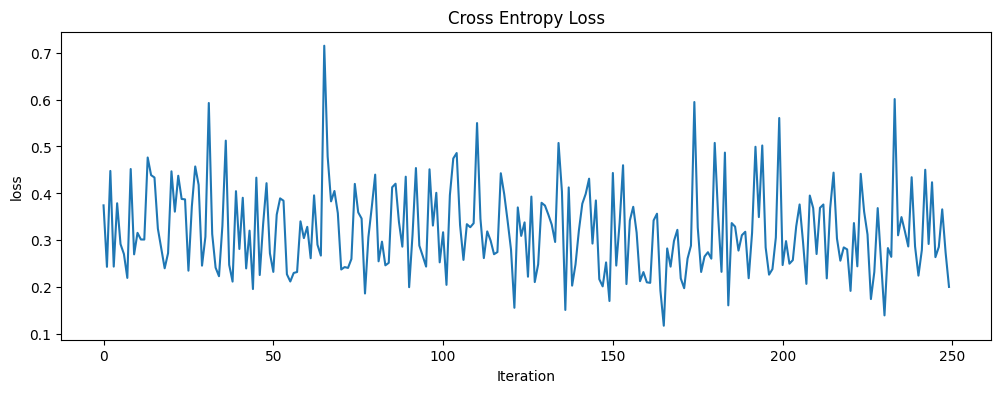

In [40]:
# Plot the loss values
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

## **Confusion Matrix**

100%|██████████| 157/157 [00:01<00:00, 150.15it/s]


[[0.807 0.001 0.014 0.045 0.005 0.002 0.111 0.    0.015 0.   ]
 [0.003 0.967 0.    0.024 0.003 0.    0.002 0.    0.001 0.   ]
 [0.015 0.002 0.755 0.017 0.131 0.001 0.073 0.    0.006 0.   ]
 [0.018 0.011 0.011 0.897 0.029 0.    0.027 0.    0.007 0.   ]
 [0.001 0.001 0.077 0.04  0.818 0.    0.054 0.    0.009 0.   ]
 [0.    0.    0.    0.001 0.    0.943 0.    0.037 0.003 0.016]
 [0.118 0.002 0.079 0.045 0.08  0.    0.657 0.    0.019 0.   ]
 [0.    0.    0.    0.    0.    0.023 0.    0.95  0.    0.027]
 [0.001 0.001 0.003 0.009 0.004 0.002 0.009 0.005 0.966 0.   ]
 [0.    0.    0.    0.    0.    0.009 0.    0.04  0.001 0.95 ]]


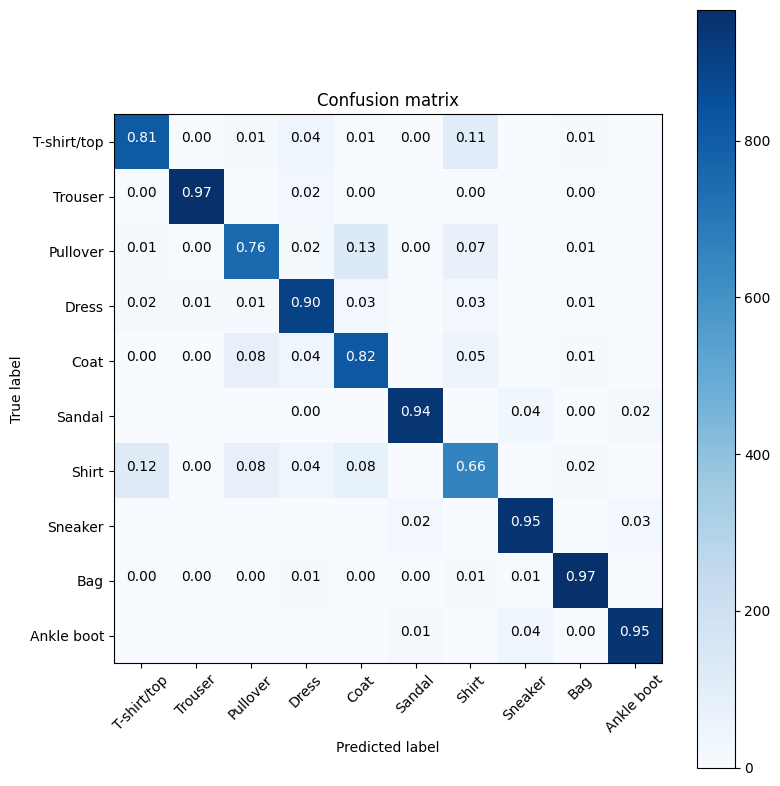

In [52]:
y_pred, y_true = predict_class(model, test_dataloader, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, training_data.classes, normalize=True, figsize=(8, 8))

## **Saving the Model Weights**


In [ ]:
import torchvision.models as models

model = models.vgg16(weights="IMAGENET1K_V1")
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.5MB/s]
